In [43]:
%matplotlib inline

import random

import h5py
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

plt.style.use('ggplot')

In [24]:
domain = "shadow"
splits = ("training_member", "non_training_member", "non_member")
epoch = 25000
distances = ("l2 norm (pairwise)", "l2 norm (center)", "cosine (pairwise)", "cosine (center)")
shadow_sim = {d: {s: None for s in splits} for d in distances}
for split in splits:
    print(f"Split: {split}")
    identities = []
    with open(f"../splitted_data/{domain}_{split}.csv", "r") as f:
        for line in f:
            identities.append(line.split(",")[0])
    identities = np.array(identities)
    unique_ids = set(identities.tolist())
    ids = []
    for i in set(identities.tolist()):
        if i == '-1':
            continue
        ids.append(np.where(identities == i)[0])
    print(f"# of identities: {len(ids)}")

    with h5py.File(f"../experiments/{domain}/market1501_{domain}_{split}_embeddings_{epoch}.h5", "r") as f:
        # print(f.keys())
        data = np.vstack(list(f['emb']))

    cos_paired = []
    l2_paired = []
    cos_center = []
    l2_center = []
    for i in ids:
        if len(i) > 1:
            cos_paired.append(np.ma.masked_values(np.triu(cosine_similarity(data[i,:]), k=1), 0).mean())
            l2_paired.append(np.ma.masked_values(np.triu(euclidean_distances(data[i,:]), k=1), 0).mean())
            cos_center.append(cosine_similarity(data[i, :].mean(axis=0).reshape(1,-1), data[i,:]).mean())
            l2_center.append(euclidean_distances(data[i, :].mean(axis=0).reshape(1,-1), data[i,:]).mean())
        else:
            cos_paired.append(-1)
            l2_paired.append(-1)
            cos_center.append(-1)
            l2_center.append(-1)
    shadow_sim["cosine (pairwise)"][split] = np.array(cos_paired)
    shadow_sim["l2 norm (pairwise)"][split] = np.array(l2_paired)
    shadow_sim["cosine (center)"][split] = np.array(cos_center)
    shadow_sim["l2 norm (center)"][split] = np.array(l2_center)

Split: training_member
# of identities: 373
Split: non_training_member
# of identities: 373
Split: non_member
# of identities: 375


In [25]:
for d in distances:
    print(f"===== {d} =====")
    for split in splits:
        print(f"{split}: {shadow_sim[d][split][shadow_sim[d][split] >= 0].mean()}")

===== l2 norm (pairwise) =====
training_member: 9.308797782731897
non_training_member: 12.566275416202227
non_member: 14.501852317595185
===== l2 norm (center) =====
training_member: 6.0995618712288255
non_training_member: 8.25553835539714
non_member: 9.987756729125977
===== cosine (pairwise) =====
training_member: 0.9491148693548501
non_training_member: 0.8886079683734739
non_member: 0.8165071972614918
===== cosine (center) =====
training_member: 0.9779236098615135
non_training_member: 0.9512102475956731
non_member: 0.909733235836029


In [26]:
domain = "ground_truth"
epochs = range(0, 25000+1, 5000)
target_sim = {d: {s: [] for s in splits} for d in distances}
for split in splits:
    print(f"Split: {split}")
    identities = []
    with open(f"../splitted_data/{domain}_{split}.csv", "r") as f:
        for line in f:
            identities.append(line.split(",")[0])
    identities = np.array(identities)
    unique_ids = set(identities.tolist())
    ids = []
    for i in set(identities.tolist()):
        if i == '-1':
            continue
        ids.append(np.where(identities == i)[0])
    print(f"# of identities: {len(ids)}")

    for epoch in epochs:
        with h5py.File(f"../experiments/target/market1501_{domain}_{split}_embeddings_{epoch}.h5", "r") as f:
            # print(f.keys())
            data = np.vstack(list(f['emb']))

        cos_paired = []
        l2_paired = []
        cos_center = []
        l2_center = []
        for i in ids:
            if len(i) > 1:
                cos_paired.append(np.ma.masked_values(np.triu(cosine_similarity(data[i,:]), k=1), 0).mean())
                l2_paired.append(np.ma.masked_values(np.triu(euclidean_distances(data[i,:]), k=1), 0).mean())
                cos_center.append(cosine_similarity(data[i, :].mean(axis=0).reshape(1,-1), data[i,:]).mean())
                l2_center.append(euclidean_distances(data[i, :].mean(axis=0).reshape(1,-1), data[i,:]).mean())
            else:
                cos_paired.append(-1)
                l2_paired.append(-1)
                cos_center.append(-1)
                l2_center.append(-1)
        target_sim["cosine (pairwise)"][split].append(np.array(cos_paired))
        target_sim["l2 norm (pairwise)"][split].append(np.array(l2_paired))
        target_sim["cosine (center)"][split].append(np.array(cos_center))
        target_sim["l2 norm (center)"][split].append(np.array(l2_center))

Split: training_member
# of identities: 375
Split: non_training_member
# of identities: 373
Split: non_member
# of identities: 376


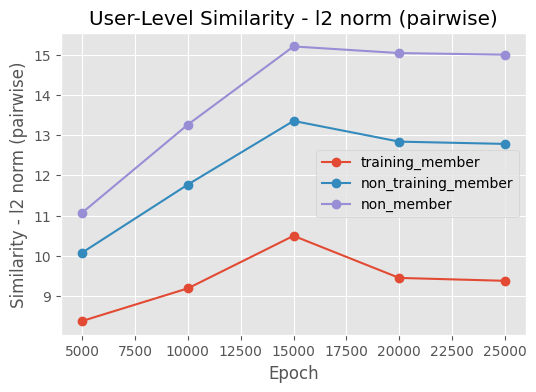

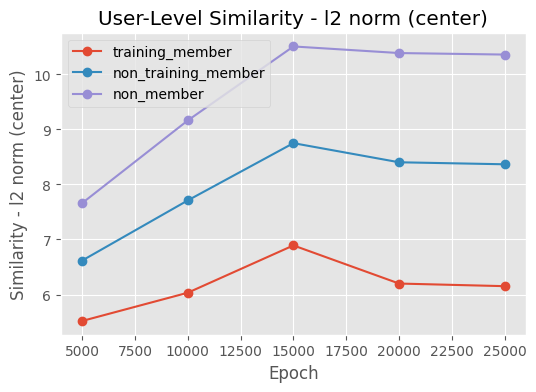

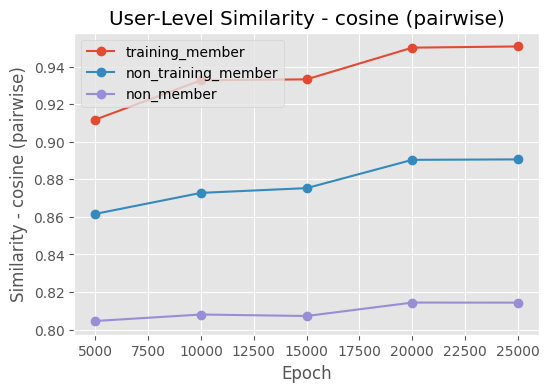

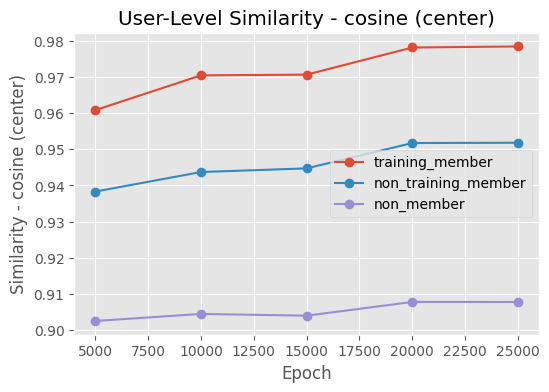

In [27]:
for d in distances:
    plt.figure(dpi=100)
    for ss in target_sim[d].values():
        plt.plot(epochs[1:], [s[s >= 0].mean() for s in ss[1:]], "-o")
    plt.title(f"User-Level Similarity - {d}")
    plt.xlabel("Epoch")
    plt.ylabel(f"Similarity - {d}")
    plt.legend(target_sim[d].keys())
    plt.show()

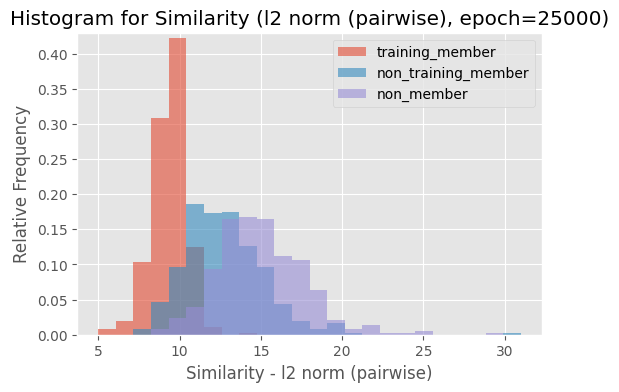

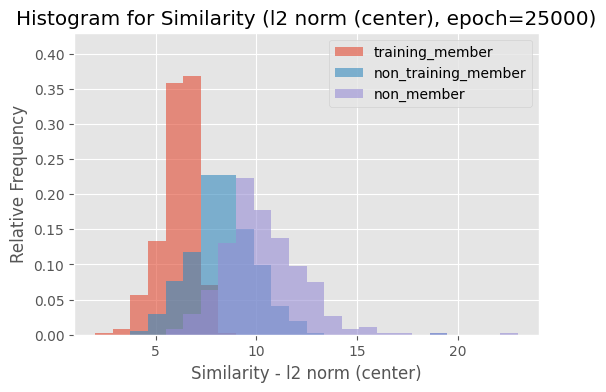

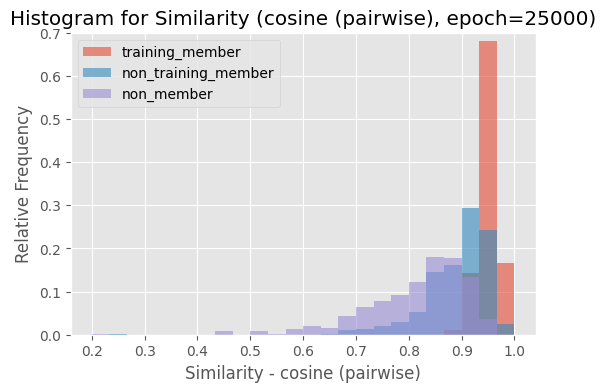

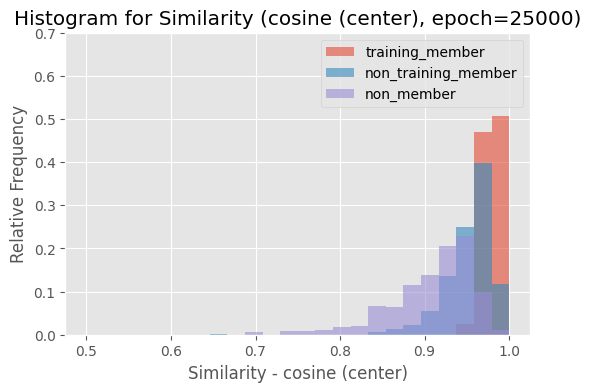

In [33]:
bins_list = (np.linspace(5, 31, 25), np.linspace(2, 23, 25), np.linspace(.2, 1, 25), np.linspace(.5, 1, 25))
ylim_list = (.43, .43, .7, .7)
for d, bins, ylim in zip(distances, bins_list, ylim_list):
    epoch_idx = -1
    plt.figure(dpi=100)
    for ss in target_sim[d].values():
        plt.hist(ss[epoch_idx][ss[epoch_idx] >= 0], bins, weights=np.ones_like(ss[epoch_idx][ss[epoch_idx] >= 0]) / len(ss[epoch_idx][ss[epoch_idx] >= 0]), alpha=.6)
    plt.title(f"Histogram for Similarity ({d}, epoch={epochs[epoch_idx]})")
    plt.xlabel(f"Similarity - {d}")
    plt.ylabel("Relative Frequency")
    plt.ylim(0, ylim)
    plt.legend(target_sim[d].keys())
    plt.show()

In [34]:
split = "non_training_member"
all_sim = {d: [(s, 1) for s in sim[split][sim[split] >= 0]] for d, sim in shadow_sim.items()}
true_cnt = len(all_sim[distances[0]])

split = "non_member"
for d in distances:
    all_sim[d].extend([(s, 0) for s in shadow_sim[d][split][shadow_sim[d][split] >= 0]])

len(all_sim[distances[0]]), true_cnt / len(all_sim[distances[0]])

(743, 0.4952893674293405)

In [35]:
mia = {}
target_min = ["l2 norm (pairwise)", "l2 norm (center)"]
for d, sim in all_sim.items():
    if d in target_min:
        correct = len(sim) - true_cnt
    else:
        correct = true_cnt
    best_pivot = -1
    best_correct = correct

    sorted_sim = sorted(sim, reverse=(d in target_min))
    for i, (s, l) in enumerate(sorted_sim):
        if l == 1:
            correct -= 1
        else:
            correct += 1
        if correct > best_correct:
            best_correct = correct
            pivot = i

    if pivot == -1:
        threshold = sorted_sim[0][0] + (-1e-5 if d in target_min else 1e-5)
    elif pivot < len(sim) - 1:
        threshold = (sorted_sim[pivot][0] + sorted_sim[pivot+1][0]) / 2
    else:
        threshold = sorted_sim[pivot][0] + (1e-5 if d in target_min else -1e-5)

    mia[d] = {
        "threshold": threshold,
        "shadow accuracy": best_correct / len(sim)
    }

mia

{'l2 norm (pairwise)': {'threshold': 12.564941387498799,
  'shadow accuracy': 0.6877523553162853},
 'l2 norm (center)': {'threshold': 8.777234077453613,
  'shadow accuracy': 0.7227456258411844},
 'cosine (pairwise)': {'threshold': 0.881689814004031,
  'shadow accuracy': 0.7348586810228802},
 'cosine (center)': {'threshold': 0.9454829692840576,
  'shadow accuracy': 0.7590847913862718}}

In [36]:
result = {}
for d, sim in target_sim.items():
    epochs = range(0, 25000+1, 5000)
    precision = []
    recall = []
    accuracy = []
    for i in range(len(epochs)):
        if d in target_min:
            tp = sum(s <= mia[d]["threshold"] for s in sim["non_training_member"][i])
            fn = sum(s > mia[d]["threshold"] for s in sim["non_training_member"][i])
            tn = sum(s > mia[d]["threshold"] for s in sim["non_member"][i])
            fp = sum(s <= mia[d]["threshold"] for s in sim["non_member"][i])
        else:
            tp = sum(s > mia[d]["threshold"] for s in sim["non_training_member"][i])
            fn = sum(s <= mia[d]["threshold"] for s in sim["non_training_member"][i])
            tn = sum(s <= mia[d]["threshold"] for s in sim["non_member"][i])
            fp = sum(s > mia[d]["threshold"] for s in sim["non_member"][i])
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
        accuracy.append((tp + tn) / (tp + fn + tn +fp))
    result[d] = {
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy
    }

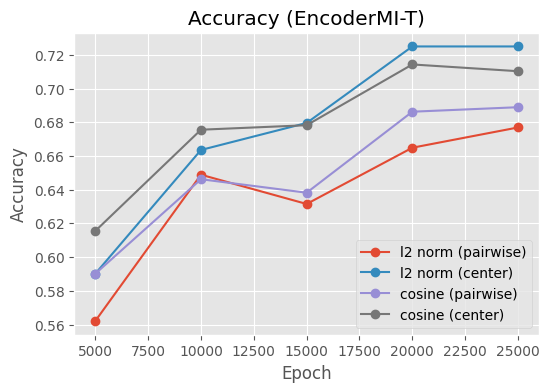

In [39]:
plt.figure(dpi=100)
for r in result.values():
    plt.plot(epochs[1:], r["accuracy"][1:], "-o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (EncoderMI-T)")
plt.legend(result.keys())
plt.show()

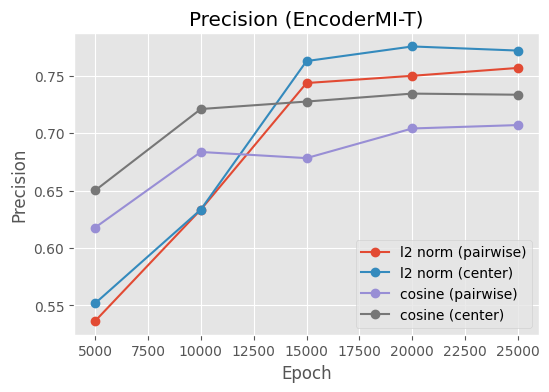

In [37]:
plt.figure(dpi=100)
for r in result.values():
    plt.plot(epochs[1:], r["precision"][1:], "-o")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision (EncoderMI-T)")
plt.legend(result.keys())
plt.show()

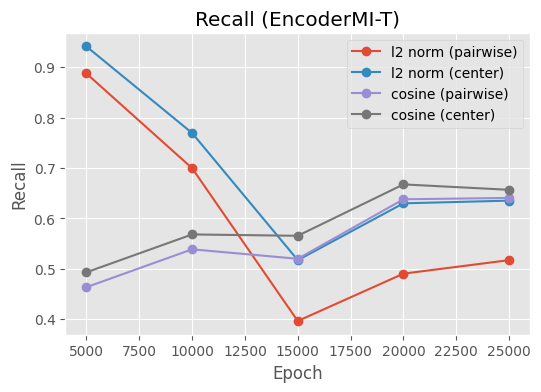

In [38]:
plt.figure(dpi=100)
for r in result.values():
    plt.plot(epochs[1:], r["recall"][1:], "-o")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall (EncoderMI-T)")
plt.legend(result.keys())
plt.show()

In [42]:
for d, r in result.items():
    print(f"===== {d} =====")
    for k, v in r.items():
        print(f"{k}: {v[-1]}")

===== l2 norm (pairwise) =====
precision: 0.7568627450980392
recall: 0.517426273458445
accuracy: 0.6769025367156208
===== l2 norm (center) =====
precision: 0.7719869706840391
recall: 0.6353887399463807
accuracy: 0.7249666221628839
===== cosine (pairwise) =====
precision: 0.7071005917159763
recall: 0.6407506702412868
accuracy: 0.6889185580774366
===== cosine (center) =====
precision: 0.7335329341317365
recall: 0.6568364611260054
accuracy: 0.7102803738317757


In [71]:
ensemble_distances = ("l2 norm (center)", "cosine (center)", "cosine (pairwise)")
def is_member(sim, split, i, j):
    vote_member = 0
    for d in ensemble_distances:
        if (d in target_min and sim[d][split][i][j] <= mia[d]["threshold"]) or (d not in target_min and sim[d][split][i][j] > mia[d]["threshold"]):
            vote_member += 1
    if vote_member > len(ensemble_distances) / 2:
        return True
    if vote_member < len(ensemble_distances) / 2:
        return False
    return random.random() < 0.5

epochs = range(0, 25000+1, 5000)
precision = []
recall = []
accuracy = []
for i in range(len(epochs)):
    split = "non_training_member"
    tp = sum(is_member(target_sim, split, i, j) for j in range(len(target_sim[distances[0]][split][i])))
    fn = len(target_sim[distances[0]][split][i]) - tp
    split = "non_member"
    fp = sum(is_member(target_sim, split, i, j) for j in range(len(target_sim[distances[0]][split][i])))
    tn = len(target_sim[distances[0]][split][i]) - fp
    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))
    accuracy.append((tp + tn) / (tp + fn + tn +fp))

In [72]:
accuracy, precision, recall

([0.5180240320427236,
  0.6114819759679573,
  0.664886515353805,
  0.671562082777036,
  0.7076101468624834,
  0.7076101468624834],
 [0.9285714285714286,
  0.6366666666666667,
  0.6967741935483871,
  0.7212543554006968,
  0.7291666666666666,
  0.7319277108433735],
 [0.03485254691689008,
  0.5120643431635389,
  0.579088471849866,
  0.5549597855227882,
  0.6568364611260054,
  0.6514745308310992])